In [1]:
import numpy as np
import os
import re
from collections import Counter
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import math
from qpsolvers import solve_qp
from collections import Counter
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
def data_split(dataset):
    train_data, test_data = {}, {}
    for key, values in dataset.items():
        train, test = train_test_split(values, test_size=0.5, random_state=42)
        train_data[key] = train
        test_data[key] = test
    return train_data, test_data

In [3]:
def makeDataSet(dataset, filepath):
    for files in os.listdir(filepath):
        if not os.path.isdir(f'{filepath}/{files}'): continue
        f = os.listdir(f'{filepath}/{files}')
        random.shuffle(f)
        dataset[files] = f
    return dataset

In [4]:
def getCategories(filepath):
    files = os.listdir(filepath)
    cat_table = {key: {} for key in files}
    return cat_table

In [5]:
def updateDataSet(inputs, word_bag, cat_table, cat):
    for word in inputs:
        word = word.lower()
        word_bag.append(word)

        if word not in cat_table.get(cat):
            cat_table.get(cat)[word] = 0
        cat_table.get(cat)[word] += 1
    return cat_table, word_bag

In [6]:
def prepareData(cat_table, filepath, train_data):
    cat_prob, word_bag = {}, []
    for k in tqdm(cat_table, desc=f"Loading training data ...", total =len(cat_table)):
        if not os.path.isdir(f'{filepath}/{k}'): continue
        for txt in train_data.get(k): # tqdm(train_data.get(k), desc=f'{k}', total =len(train_data.get(k))):
            with open(f'{filepath}/{k}/{txt}', 'r', encoding='latin1') as t:
                lines = t.readlines()[4:] 
                inputs = [word for line in lines for word in re.sub(r'[^\w\s]', '', line).strip().split()]
            
            cat_table, word_bag = updateDataSet(inputs, word_bag, cat_table, k)
        cat_prob[k] = len(train_data.get(k))
    return cat_table, word_bag, cat_prob

In [7]:
def makeTFdict(cat_table):
    tf_dict = {}
    for key in cat_table.keys():
        size = sum(cat_table[key].values())
        tf_dict[key] = {k: v / size for k, v in cat_table[key].items()}
    return tf_dict

In [8]:
def wordOccurrence(cat_table, word):
    occurrence = 0
    for key in cat_table.keys():
        if word in cat_table.get(key).keys():  occurrence += 1
    return occurrence

In [9]:
def makeIDFdict(cat_table):
    N = len([key for key in cat_table.keys() if key != '.DS_Store']) # + 1
    idf_dict, dFt = {}, {}
    for key in cat_table.keys():
        dFt[key] = {k: wordOccurrence(cat_table, k) for k, v in cat_table[key].items()}
        idf_dict[key] = {k: math.log10(N / v) for k, v in dFt[key].items()}
    return idf_dict

In [10]:
def tf_idf(cat_table, word_bag):
    tf_dict = makeTFdict(cat_table)
    idf_dict = makeIDFdict(cat_table)
    tf_idf_dict, tf_idf_col = {}, []
    tf_idf = np.zeros( (len(tf_dict.keys()), len(word_bag)) )
    for key in tf_dict.keys():
        tf_idf_dict[key] = {k : math.log2(1+v) for k, v in tf_dict[key].items()}

    for key in tf_idf_dict.keys():
        for k, v in tf_idf_dict[key].items():
            tf_idf_dict[key][k] = v * idf_dict[key][k]
    index = 0
    for key in tf_idf_dict.keys():
        for i, word in enumerate(word_bag):
            tf_idf[index][i] = tf_idf_dict.get(key).get(word, 0);
        index += 1
        tf_idf_col.append(key)
    
    return tf_idf, tf_idf_col

In [11]:
def makeStopWords(word_bag, size):
    stop_words = dict(sorted(Counter(word_bag).items(), key=lambda item: item[1], reverse=True))
    stop_words = [k for k, v in sorted(stop_words.items(), key=lambda item: item[1], reverse=True)[:size]]
    return stop_words

In [12]:
def getTestData(item):
    for k, v in item.items():
        key = k
        value = v
    return key, value 

In [13]:
def collectTestData(test_data, stop_words, word_bag, filepath):
    test_data_collection = []
    for key in tqdm(test_data.keys(), desc=f'Loading test data ...', total =len(test_data.keys()) ):
        for item in test_data.get(key): # tqdm(test_data.get(key), desc=f'collecting {key}', total =len(test_data.get(key))):
            with open(f'{filepath}/{key}/{item}', 'r', encoding='latin1') as f:
                lines = f.readlines()[4:]
                test_text = [word.lower() for line in lines for word in re.sub(r'[^\w\s]', '', line).strip().split()]
                test_text = [w for w in test_text if w in word_bag]
                test_text = [word for word in test_text if word not in stop_words]
                test_data_collection.append({key : test_text})

    return test_data_collection

In [14]:
def prepareTestData(test_data, stop_words, word_bag, filepath):
    test_data_collection = {}
    test_data_col = []
    index = 0
    for key in tqdm(test_data.keys(), desc=f'Loading test data ...', total =len(test_data.keys()) ):
        for item in test_data.get(key): # tqdm(test_data.get(key), desc=f'collecting {key}', total =len(test_data.get(key))):
            with open(f'{filepath}/{key}/{item}', 'r', encoding='latin1') as f:
                lines = f.readlines()[4:]
                test_text = [word.lower() for line in lines for word in re.sub(r'[^\w\s]', '', line).strip().split()]
                test_text = [w for w in test_text if w in word_bag]
                test_text = [word for word in test_text if word not in stop_words]
                test_data_col.append(key)
                test_data_collection[index] = dict(Counter(test_text))
                index += 1

    return test_data_collection, test_data_col

In [15]:
def generateLabel(tf_idf_col, key, length):
    y_vector = -np.ones((length, 1))
    index = tf_idf_col.index(key)
    # print(f'current index is {index}')
    y_vector[index][0] = 1
    return y_vector

In [16]:
def polynomialKernel(mul, degree, constant):
    return (mul + constant) ** degree

In [17]:
def rbf_kernel_val(v1, v2, gamma):
    diff = v1 - v2
    sq_dist = np.dot(diff, diff) 
    return np.exp(-gamma * sq_dist)

def qpSolverGaussian(tf_idf, y_vector, gamma):
    m = tf_idf.shape[0]
    H = np.empty((m, m))
    
    for i in range(m):
        for j in range(m):
            # K(x, y) = exp(-gamma * ||x-y||^2)
            k_val = rbf_kernel_val(tf_idf[i], tf_idf[j], gamma)
            H[i][j] = y_vector[i , 0] * y_vector[j , 0] * k_val

    c = 100
    q = -np.ones(m)
    G = -np.eye(m)
    h = np.zeros(m) + c 
    A = y_vector.T 
    b = np.array([0.0])
    
    try:
        H = H + np.eye(m) * 1e-7
        sol = solve_qp(H, q, G, h, A, b, solver="cvxopt")
        return sol
    except:
        return None

In [18]:
def qpSolver(tf_idf, y_vector, isKernel):
    m = tf_idf.shape[0]

    H = np.empty((m, m))
    if isKernel:
        for i in range(m):
            for j in range(m):
                H[i][j] = y_vector[i , 0] * y_vector[j , 0] * polynomialKernel(np.dot(tf_idf[i], tf_idf[j]), 2, 1) #polynomialKernel(np.dot(tf_idf[i], tf_idf[j]), 2, 0)
    else:
        for i in range(m):
                for j in range(m):
                    H[i][j] = y_vector[i , 0] * y_vector[j , 0] * np.dot(tf_idf[i], tf_idf[j])

    c = 100
    q = -np.ones(m)
    G = -np.eye(m)
    h = np.zeros(m) + c
    A = y_vector.T 
    b = np.array([0.0])
    sol = solve_qp(H, q, G, h, A, b, solver="cvxopt")
    return sol

In [19]:
def KernelSVM(tf_idf, tf_idf_col, word_bag):
    W, b = np.ones( (len(tf_idf_col), len(word_bag)) ), np.ones( (len(tf_idf_col), 1) )
    non_sol = []
    existE = False
    for key in tqdm(tf_idf_col, desc="Generating Kernel Function SVM Classifiers ...", total=len(tf_idf_col)) :
        y_vector = generateLabel(tf_idf_col, key, len(tf_idf_col))
        BC_index = tf_idf_col.index(key)
        sol = qpSolver(tf_idf, y_vector, isKernel= True)
        if sol is None: 
            existE = True
            non_sol.append(BC_index)
            continue
        index = np.where(sol > 0)[0][0]
        M = 0
        for i in range(tf_idf.shape[0]):
            partial_p = sol[i] * y_vector[i][0]
            x_vector = tf_idf[i]
            for j in range(tf_idf.shape[1]):
                W[BC_index][j] += partial_p * x_vector[j]
        M = np.dot(W[BC_index], tf_idf[index])
        if (index == BC_index):
            b[BC_index] = 1 - M
        else:
            b[BC_index] = - 1 - M
    if existE: print("[INFO] Exist Binary Classifier(s) not solvable. Test accuracy may be effected this time, modify kernel function to improve next time!")
    return W, b

In [20]:
def softMarginSVM(tf_idf, tf_idf_col, word_bag):
    W, b = np.zeros( (len(tf_idf_col), len(word_bag)) ), np.zeros( (len(tf_idf_col), 1) )
    for key in tqdm(tf_idf_col, desc="Generating Soft Margin SVM Classifiers ...", total=len(tf_idf_col)) :
        y_vector = generateLabel(tf_idf_col, key, len(tf_idf_col))
        BC_index = tf_idf_col.index(key)
        sol = qpSolver(tf_idf, y_vector, isKernel=False)
        index = np.where(sol > 0)[0][0]
        M = 0
        for i in range(tf_idf.shape[0]):
            partial_p = sol[i] * y_vector[i][0]
            x_vector = tf_idf[i]
            for j in range(tf_idf.shape[1]):
                W[BC_index][j] += partial_p * x_vector[j]
        M = np.dot(W[BC_index], tf_idf[index])
        if (index == BC_index):
            b[BC_index] = 1 - M
        else:
            b[BC_index] = - 1 - M
    return W, b

In [21]:
def GaussianSVM(tf_idf, tf_idf_col, word_bag):
    W, b = np.zeros( (len(tf_idf_col), len(word_bag)) ), np.zeros( (len(tf_idf_col), 1) )
    non_sol = []
    gamma = 1.0 / len(word_bag) 
    
    for key in tqdm(tf_idf_col, desc="Generating Gaussian SVM Classifiers ...", total=len(tf_idf_col)) :
        y_vector = generateLabel(tf_idf_col, key, len(tf_idf_col))
        BC_index = tf_idf_col.index(key)
        # qpsolver for Gaussian only
        sol = qpSolverGaussian(tf_idf, y_vector, gamma)
        
        if sol is None: 
            print(f"[WARN] Solver failed for class {key}")
            non_sol.append(BC_index)
            continue
        try:
            index = np.where(sol > 1e-5)[0][0] 
        except:
            index = 0     
        M = 0
        for i in range(tf_idf.shape[0]):
            partial_p = sol[i] * y_vector[i][0]
            x_vector = tf_idf[i]
            for j in range(tf_idf.shape[1]):
                W[BC_index][j] += partial_p * x_vector[j]
    
        M = np.dot(W[BC_index], tf_idf[index])
        if (index == BC_index):
            b[BC_index] = 1 - M
        else:
            b[BC_index] = - 1 - M
    return W, b

## README ##

Hi,

I already created a general tf-idf function above. Since the test data contains 9999 documents, it may take a long time to processing(around 50 mins when I tried on my device). 

However, the function testDataVectorizer below is the tf-idf processing function only for the test data. I used numpy vectorization to get the tf-idf vector and matrix for the test data, which is quicker then make it row by row(tf-idf function above). The code logic of testDataVectorizer is 100% same as tf-idf function above! 

Thank you!


In [22]:
def testDataVectorizer(test_data_list, word_bag):

    test_data_tf_dict = np.zeros( ( len(test_data_list), len(word_bag) ) )
    test_vector_col = []
    word_index = {word: idx for idx, word in enumerate(word_bag)}
    
    print("Vectorizing test data ...... This may take a long time ......")
    for i, word_dict in enumerate(test_data_list): #desc=f'Loading test data', total =len(test_data_list)):
        all_words = [word for words in word_dict.values() for word in words]
        word_count = Counter(all_words)
        size = sum(word_count.values())
        test_vector_col.append(list(word_dict.keys()))

        for word, count in word_count.items():
            if word in word_index: 
                col_idx = word_index[word]
                test_data_tf_dict[i][col_idx] = count / size

    start_time = time.time()

    M = np.zeros_like(test_data_tf_dict)
    n_rows = len(test_data_list)
    count_per_column = np.count_nonzero(test_data_tf_dict, axis=0)
    idf_values = np.log10(n_rows / (count_per_column + (count_per_column == 0))) 
    M = np.tile(idf_values, (n_rows, 1)) 
    t = np.log2(1 + test_data_tf_dict) * M

    end_time = time.time()
    print(f'Test data vectorized successfully! Took {end_time - start_time} seconds in vectorizing test data')
    print()

    return t, test_vector_col

In [23]:
def SVM_Model(W, b, test_matrix, test_vector_col, tf_idf_col, desc):
    count, num = 0, W.shape[0]
    for i in tqdm(range(test_matrix.shape[0]), desc=f'Testing {desc} svm ....', total=test_matrix.shape[0]):
        max_pred, index = 0, 0
        for j in range(num):
            predict = np.dot(test_matrix[i], W[j]) + b[j][0]
            if predict > max_pred:
                max_pred = predict 
                index = j
        if test_vector_col[i][0] == tf_idf_col[index]: count += 1
    print(f'There are {test_matrix.shape[0]} test cases, the svm classifier correctly predicted {count} cases!')
    return count / test_matrix.shape[0]

In [24]:
def SVM_Model_Get_Preds(W, b, test_matrix, test_vector_col, tf_idf_col, desc):
    y_pred = []
    y_true = [item[0] for item in test_vector_col] 
    num = W.shape[0]
    count = 0
    for i in tqdm(range(test_matrix.shape[0]), desc=f'Testing {desc} svm ....', total=test_matrix.shape[0]):
        max_pred, index = -float('inf'), 0
        for j in range(num):
            predict = np.dot(test_matrix[i], W[j]) + b[j][0]
            if predict > max_pred:
                max_pred = predict 
                index = j
        predicted_class = tf_idf_col[index]
        y_pred.append(predicted_class)
        if y_true[i] == predicted_class:
            count += 1
            
    accuracy = count / test_matrix.shape[0]
    print(f'[{desc}] Accuracy: {accuracy * 100:.2f}%\n')
    return y_true, y_pred, accuracy

def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    
    plt.title(title, fontsize=15)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Loading training data ...: 100%|██████████| 21/21 [00:03<00:00,  6.56it/s]


 ######### [INFO]Training data load successfully! #########



Generating Gaussian SVM Classifiers ...: 100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


 ######### [INFO]Training SVMs successfully! ########## 




Loading test data ...: 100%|██████████| 20/20 [00:02<00:00,  6.93it/s]


Vectorizing test data ...... This may take a long time ......
Test data vectorized successfully! Took 38.6426568031311 seconds in vectorizing test data

 ######### [INFO]Test data load successfully! #########

##### Test for SVMs #####


Testing Soft Margin svm ....: 100%|██████████| 9999/9999 [00:13<00:00, 762.33it/s]


[Soft Margin] Accuracy: 83.11%



Testing Polynomial Kernel svm ....: 100%|██████████| 9999/9999 [00:12<00:00, 774.33it/s]


[Polynomial Kernel] Accuracy: 81.99%



Testing Gaussian svm ....: 100%|██████████| 9999/9999 [00:13<00:00, 763.14it/s]


[Gaussian] Accuracy: 83.60%

Plotting Confusion Matrix for Gaussian SVM...


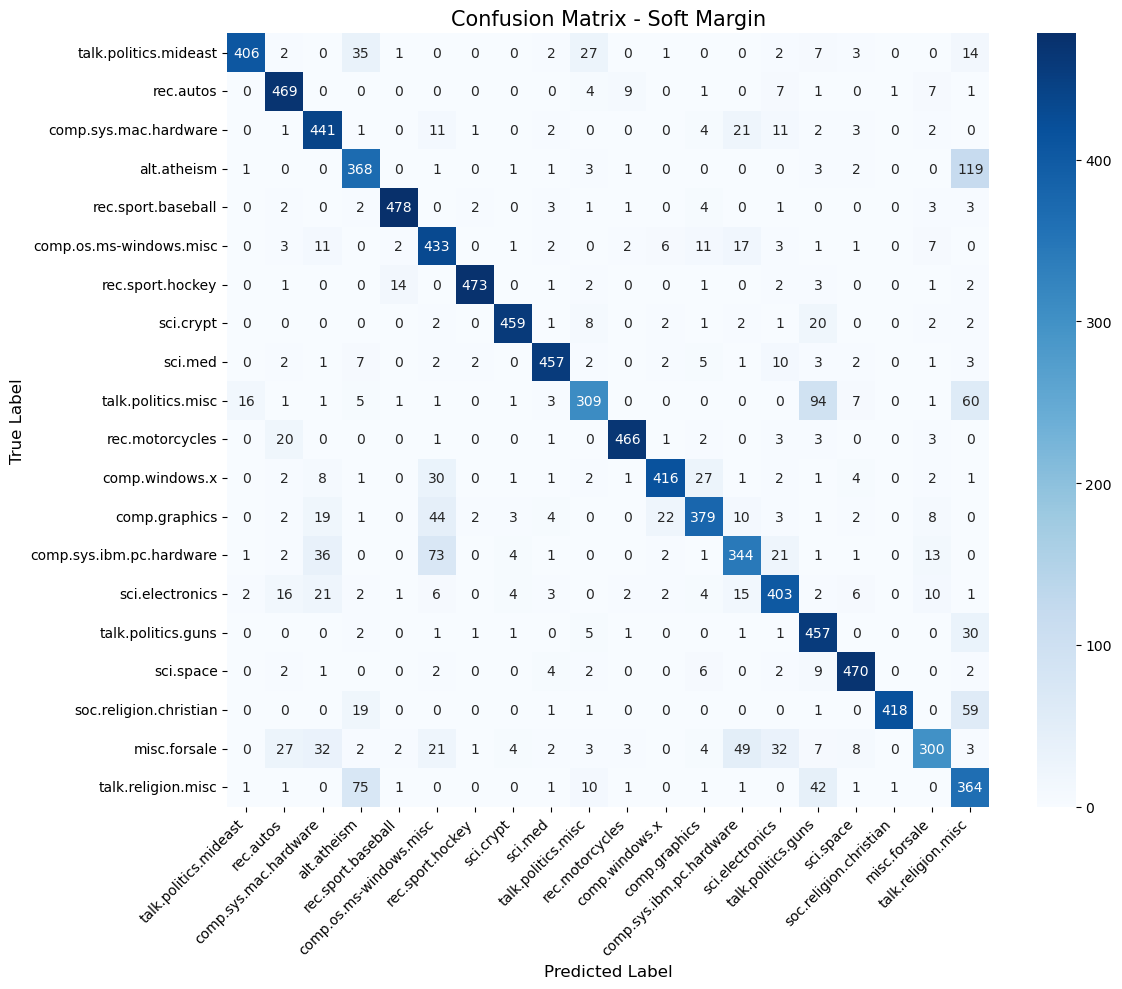

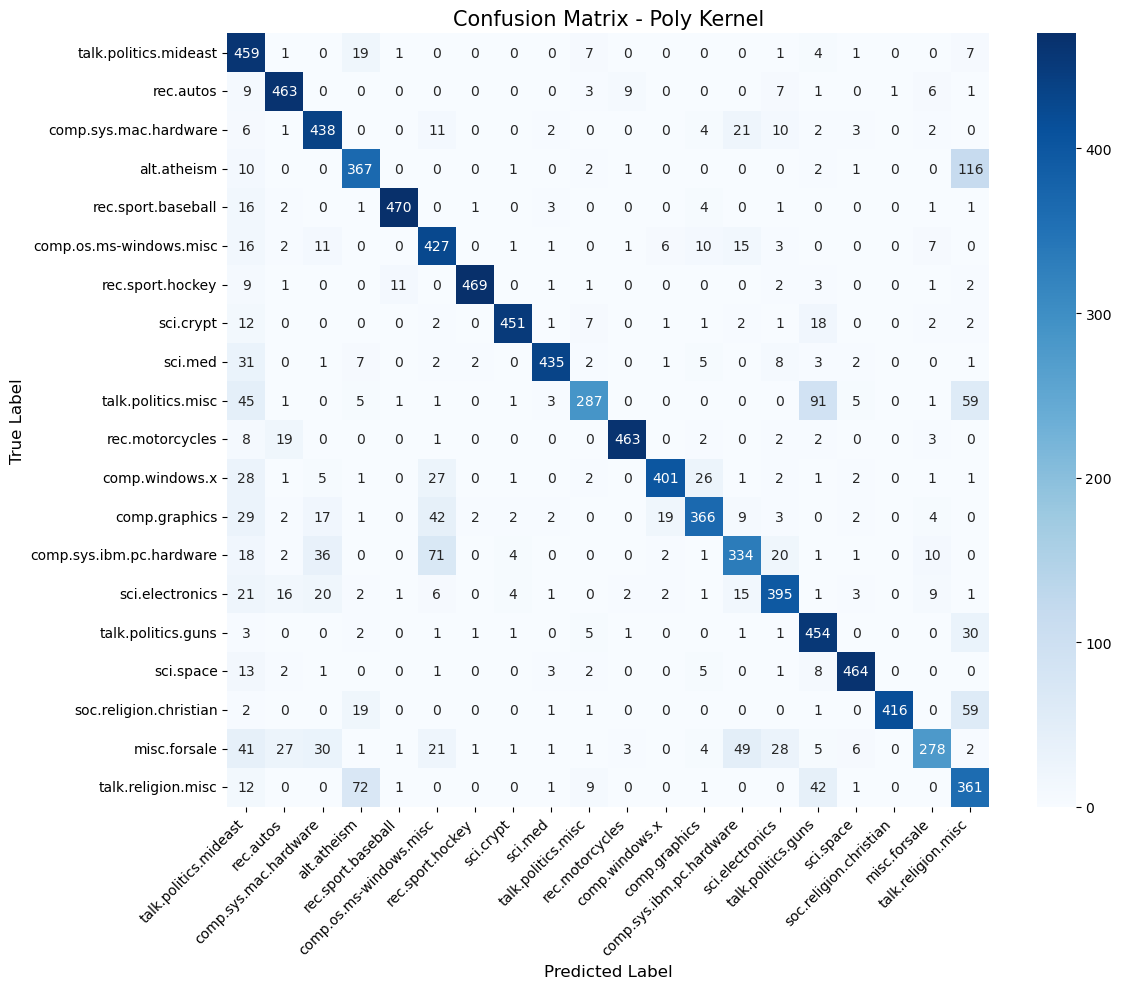

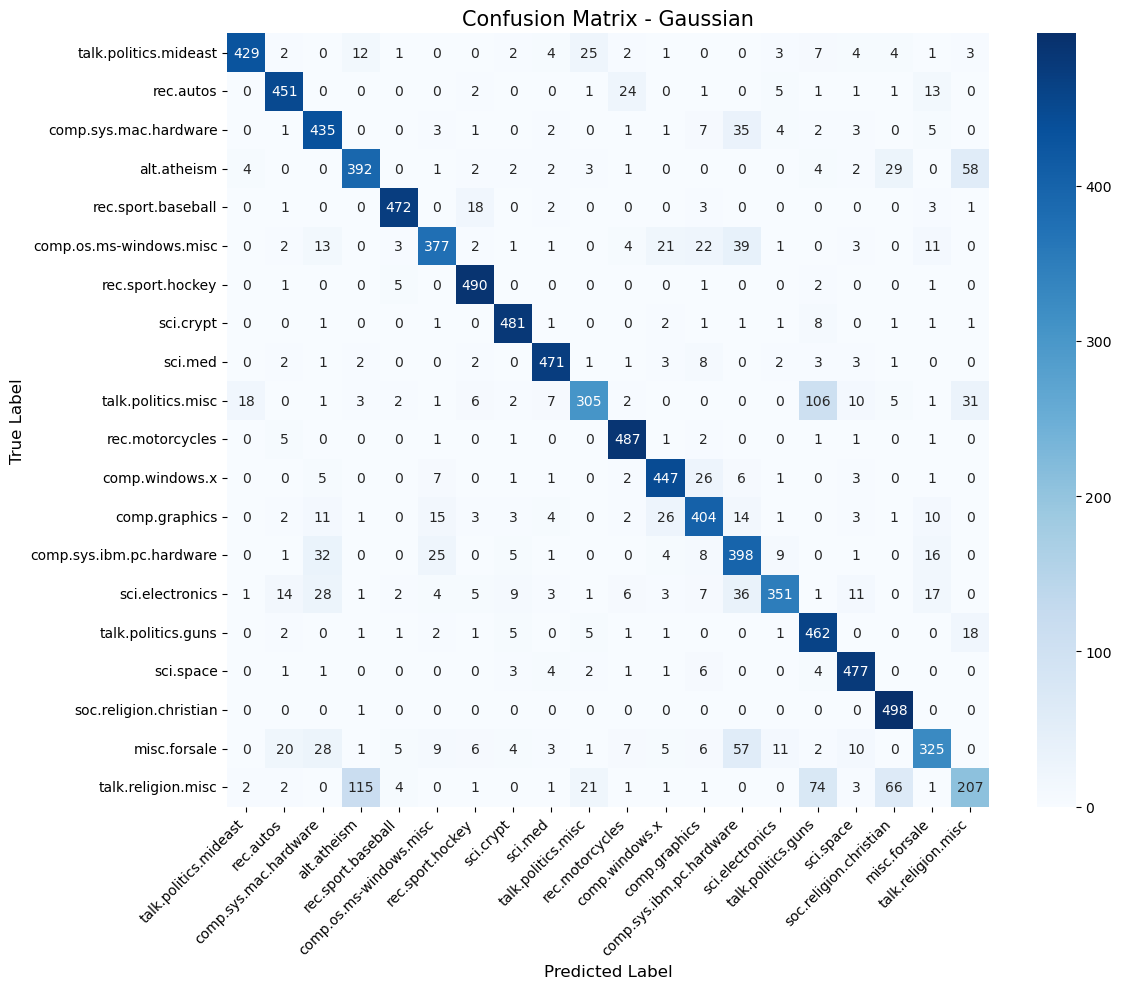

In [25]:
if __name__ == '__main__':

    filepath = './data/20_newsgroups'

    dataset = makeDataSet({}, filepath)
    train_data, test_data_set = data_split(dataset)
    cat_table = getCategories(filepath)

    print()
    cat_table, word_bag, cat_prob = prepareData(cat_table, filepath, train_data)
    cat_table.pop('.DS_Store', None)

    stop_words = makeStopWords(word_bag, 300)
    stop_words = set(stop_words)
    word_bag = set(word_bag) - stop_words
    
    # Get training data
    tf_idf_train, tf_idf_col = tf_idf(cat_table, sorted(word_bag))
    print(' ######### [INFO]Training data load successfully! #########\n')

    # Training SVM
    W_soft_margin, b_soft_maring = softMarginSVM(tf_idf_train, tf_idf_col, sorted(word_bag))
    W_kernel, b_kernel = KernelSVM(tf_idf_train, tf_idf_col, sorted(word_bag))
    W_gauss, b_gauss = GaussianSVM(tf_idf_train, tf_idf_col, sorted(word_bag))
    print(' ######### [INFO]Training SVMs successfully! ########## \n')
    print()

    # Make Test data
    test_data_list = collectTestData(test_data_set, stop_words, word_bag, filepath)
    tf_idf_test, test_vector_col = testDataVectorizer(test_data_list, sorted(set(word_bag)))
    print(' ######### [INFO]Test data load successfully! #########\n')

    # Test for SVM
    print(f'##### Test for SVMs #####')
    
    # Test for Soft Margin SVM
    # accuracy_soft_margin = SVM_Model(W_soft_margin, b_soft_maring, tf_idf_test, test_vector_col, tf_idf_col, 'soft maring')
    # print(f'The prediction accuracy of soft margin svm is: {accuracy_soft_margin * 100}%\n')
    y_true_sm, y_pred_sm, accuracy_soft_margin = SVM_Model_Get_Preds(W_soft_margin, b_soft_maring, tf_idf_test, test_vector_col, tf_idf_col, 'Soft Margin')
    y_true_kernel, y_pred_kernel, accuracy_kernel = SVM_Model_Get_Preds(W_kernel, b_kernel, tf_idf_test, test_vector_col, tf_idf_col, 'Polynomial Kernel')
    y_true_gauss, y_pred_gauss, accuracy_gauss = SVM_Model_Get_Preds(W_gauss, b_gauss, tf_idf_test, test_vector_col, tf_idf_col, 'Gaussian')

    # Test for Kernel Function SVM
    # accuracy_kernel = SVM_Model(W_kernel, b_kernel, tf_idf_test, test_vector_col, tf_idf_col, 'kernel trick')
    # print(f'The prediction accuracy of kernel trick svm is: {accuracy_kernel * 100}%\n')

    # Test for Gaussian SVM
    # accuracy_gauss = SVM_Model(W_gauss, b_gauss, tf_idf_test, test_vector_col, tf_idf_col, 'gaussian')
    # print(f'The prediction accuracy of gaussian svm is: {accuracy_kernel * 100}%\n')

    class_names = tf_idf_col
    print("Plotting Confusion Matrix for Gaussian SVM...")
    plot_confusion_matrix(y_true_sm, y_pred_sm, class_names, "Confusion Matrix - Soft Margin")
    plot_confusion_matrix(y_true_kernel, y_pred_kernel, class_names, "Confusion Matrix - Poly Kernel")
    plot_confusion_matrix(y_true_gauss, y_pred_gauss, class_names, "Confusion Matrix - Gaussian")

##### Test for Sklearn SVM (Benchmark) #####
Training Sklearn SVM [Linear]...
Predicting with Sklearn SVM [Linear]...
>> The prediction accuracy of Sklearn SVM [Linear] is: 84.5785%


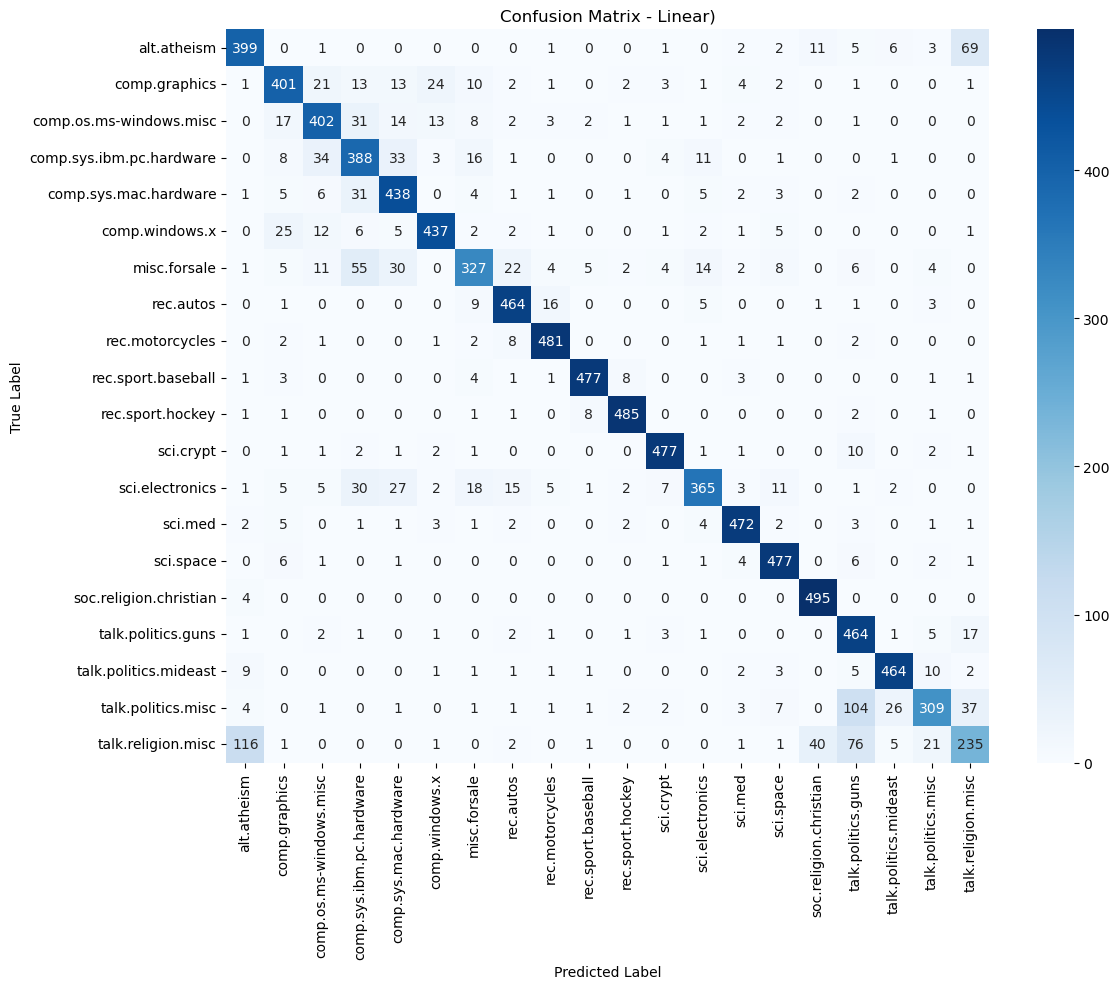

------------------------------
Training Sklearn SVM [Polynomial]...
Predicting with Sklearn SVM [Polynomial]...
>> The prediction accuracy of Sklearn SVM [Polynomial] is: 84.4284%


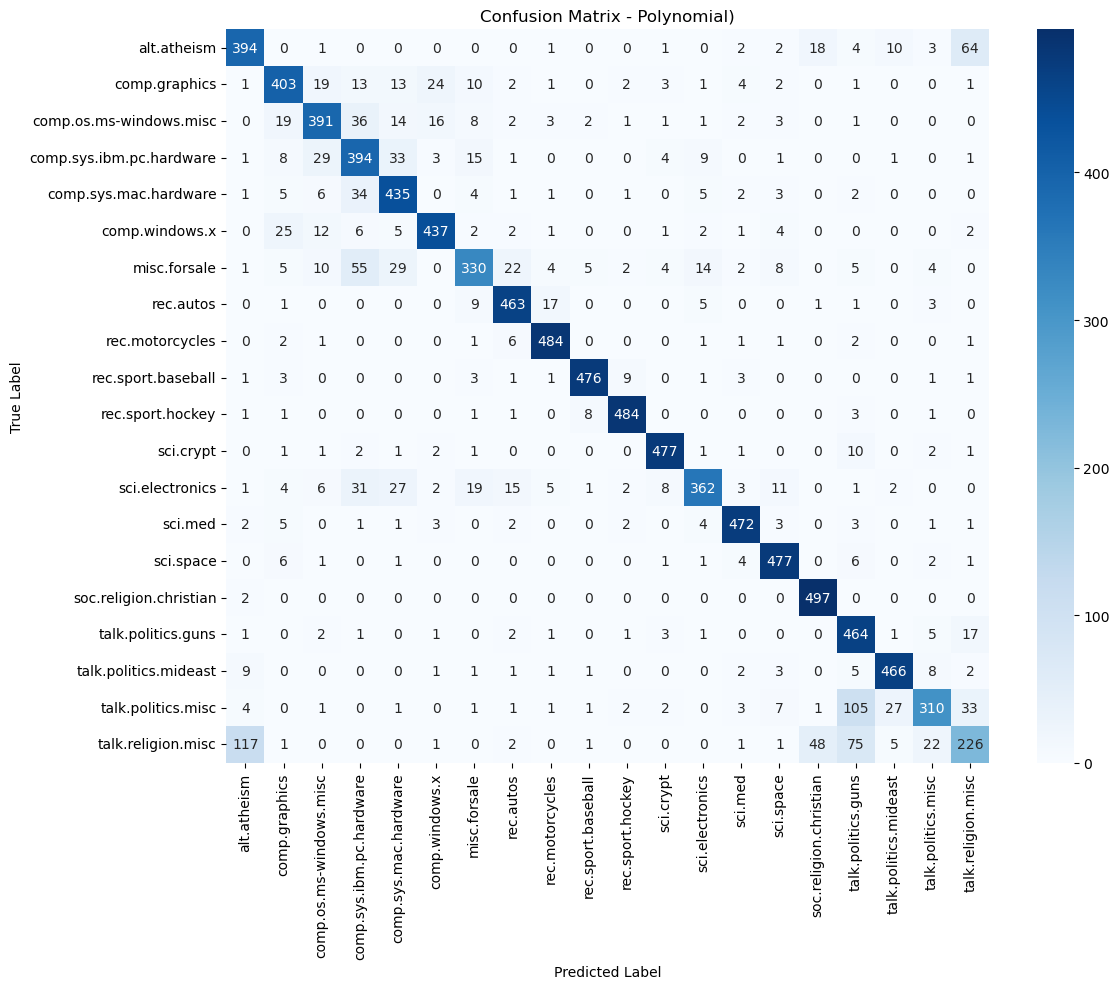

------------------------------
Training Sklearn SVM [Gaussian]...
Predicting with Sklearn SVM [Gaussian]...
>> The prediction accuracy of Sklearn SVM [Gaussian] is: 84.5785%


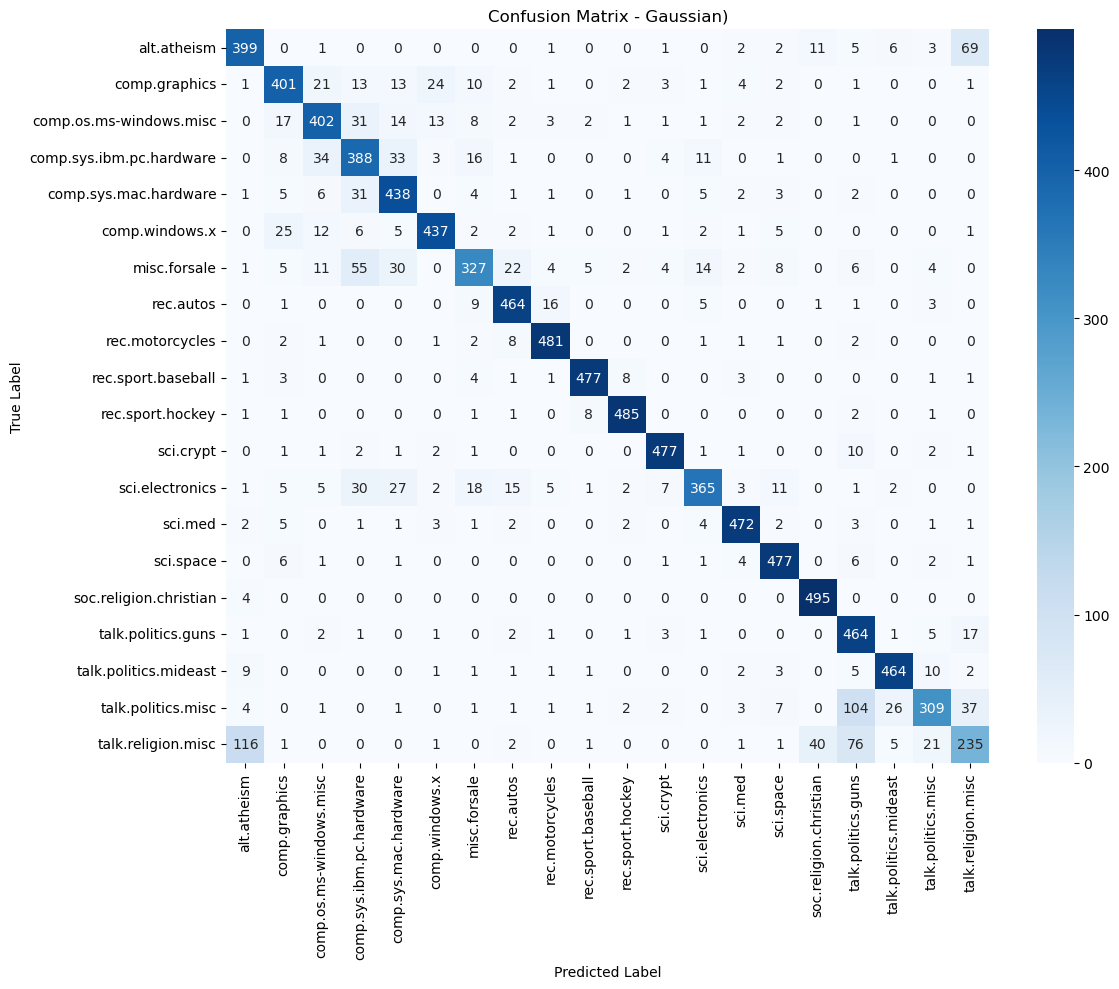

------------------------------


In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

benchmark_acc_list = []
print("##### Test for Sklearn SVM (Benchmark) #####")

X_train = tf_idf_train
y_train = tf_idf_col
X_test = tf_idf_test
y_test = [label[0] for label in test_vector_col]

unique_labels = sorted(list(set(y_test)))

models = [
    ("Linear", SVC(kernel='linear', decision_function_shape='ovr')),
    # (x^T*y + 1)^2, set degree=2, coef0=1
    ("Polynomial", SVC(kernel='poly', degree=2, coef0=1, decision_function_shape='ovr')),
    ("Gaussian", SVC(kernel='rbf', gamma='auto', decision_function_shape='ovr'))
]

for name, model in models:
    print(f"Training Sklearn SVM [{name}]...")
    model.fit(X_train, y_train)
    
    print(f"Predicting with Sklearn SVM [{name}]...")
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    benchmark_acc_list.append(acc)
    print(f'>> The prediction accuracy of Sklearn SVM [{name}] is: {acc * 100:.4f}%')
    
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(12, 10)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    
    plt.title(f'Confusion Matrix - {name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show() 
    
    print("-" * 30)

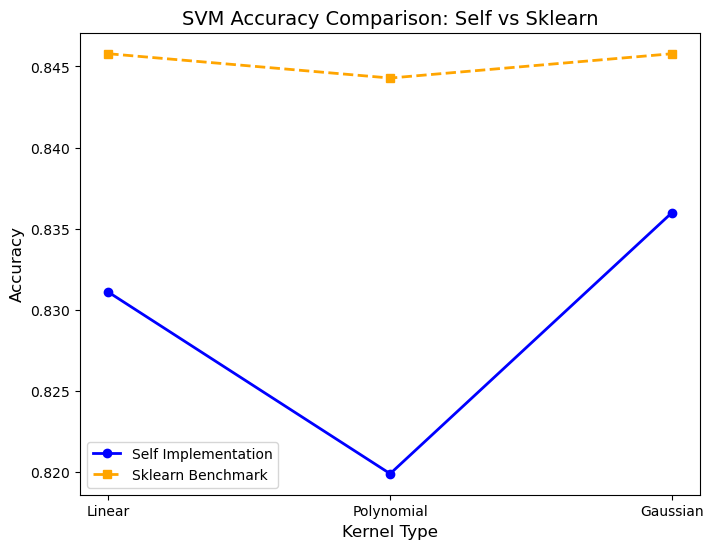

In [27]:
import matplotlib.pyplot as plt

self_svm_acc = [accuracy_soft_margin, accuracy_kernel, accuracy_gauss]
kernels = ['Linear', 'Polynomial', 'Gaussian']

plt.figure(figsize=(8, 6))


plt.plot(kernels, self_svm_acc, marker='o', linestyle='-', color='blue', label='Self Implementation', linewidth=2)
plt.plot(kernels, benchmark_acc_list, marker='s', linestyle='--', color='orange', label='Sklearn Benchmark', linewidth=2)

plt.title('SVM Accuracy Comparison: Self vs Sklearn', fontsize=14)
plt.xlabel('Kernel Type', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# plt.ylim(accuracy_soft_margin, 100) 
plt.legend()

plt.savefig("benchmark_comp.png")
plt.show()